In [ ]:
import zipfile

def extract_zip(zip_file_path, extract_to_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall()

# Example usage:
zip_file_path = 'data.zip'
extract_to_path = 'content/'

extract_zip(zip_file_path, extract_to_path)


BadZipFile: ignored

In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
from os import listdir, makedirs
from os.path import exists
import imutils
import matplotlib.pyplot as plt
import time
import numpy as np
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

%matplotlib inline

In [ ]:

def augment_data(file_dir, n_generated_samples, save_to_dir):
    """
    Arguments:
        file_dir: A string representing the directory where images that we want to augment are found.
        n_generated_samples: An integer representing the number of generated samples using the given image.
        save_to_dir: A string representing the directory in which the generated images will be saved.
    """

    # Create an ImageDataGenerator
    data_gen = ImageDataGenerator(rotation_range=10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest'
                                 )

    # Create the save_to_dir if it does not exist
    if not exists(save_to_dir):
        makedirs(save_to_dir)

    # Loop through each file in the directory
    for filename in listdir(file_dir):
        # Load the image using OpenCV
        image1 = cv2.imread(f"{file_dir}/{filename}")
        # Reshape the image to match the expected input shape for data_gen.flow
        image = image1.reshape((1,) + image1.shape)
        # Prefix of the names for the generated samples
        save_prefix = 'aug_' + filename[:-4]
        # Generate 'n_generated_samples' sample images
        i = 0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,
                                   save_prefix=save_prefix, save_format='jpg'):
            i += 1
            if i > n_generated_samples:
                break

In [ ]:
augmented_data_path = 'augment_images/'

# augment data for the examples with label equal to 'yes' representing tumurous examples
augment_data(file_dir="data/yes", n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
# augment data for the examples with label equal to 'no' representing non-tumurous examples
augment_data(file_dir="data/no", n_generated_samples=9, save_to_dir=augmented_data_path+'no')


In [2]:
def crop_brain_contour(image, plot=False):

    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)


    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')

        plt.show()

    return new_image

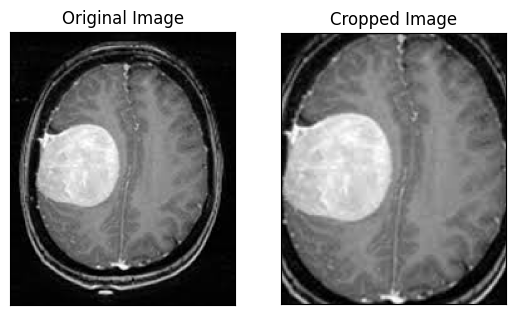

In [3]:
ex_img = cv2.imread('/content/data/yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [4]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them.
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(f"{directory}/{filename}")
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])

    X = np.array(X)
    y = np.array(y)

    # Shuffle the data
    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

In [5]:
augmented_path = '/content/augment_images/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = "/content/augment_images/yes"
augmented_no =  "/content/augment_images/no"

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


In [6]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1 # current plot
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            # remove ticks
            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

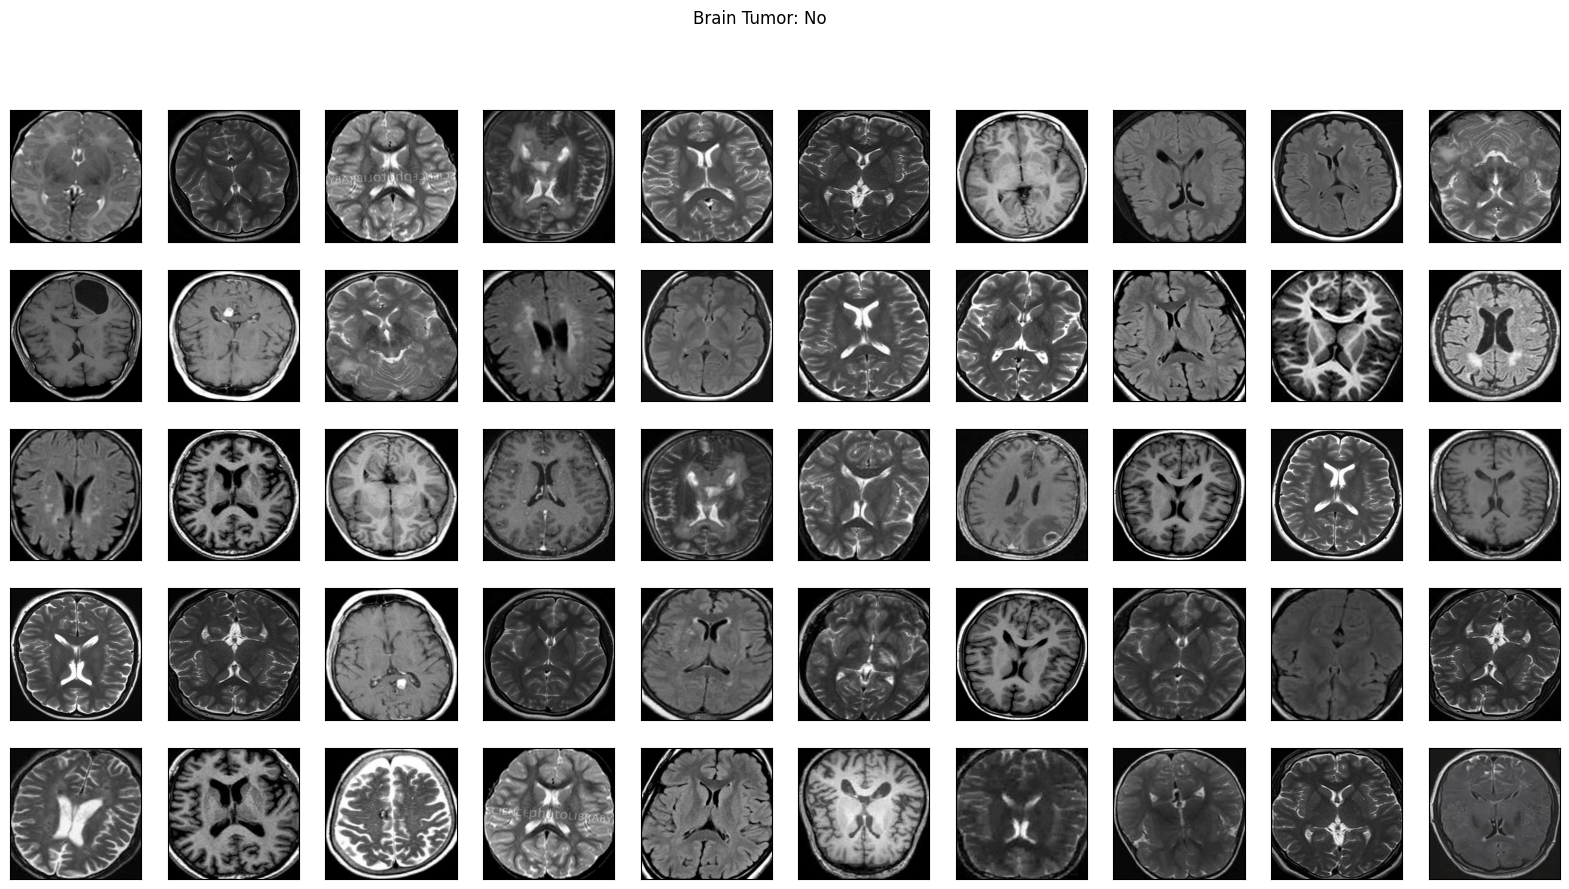

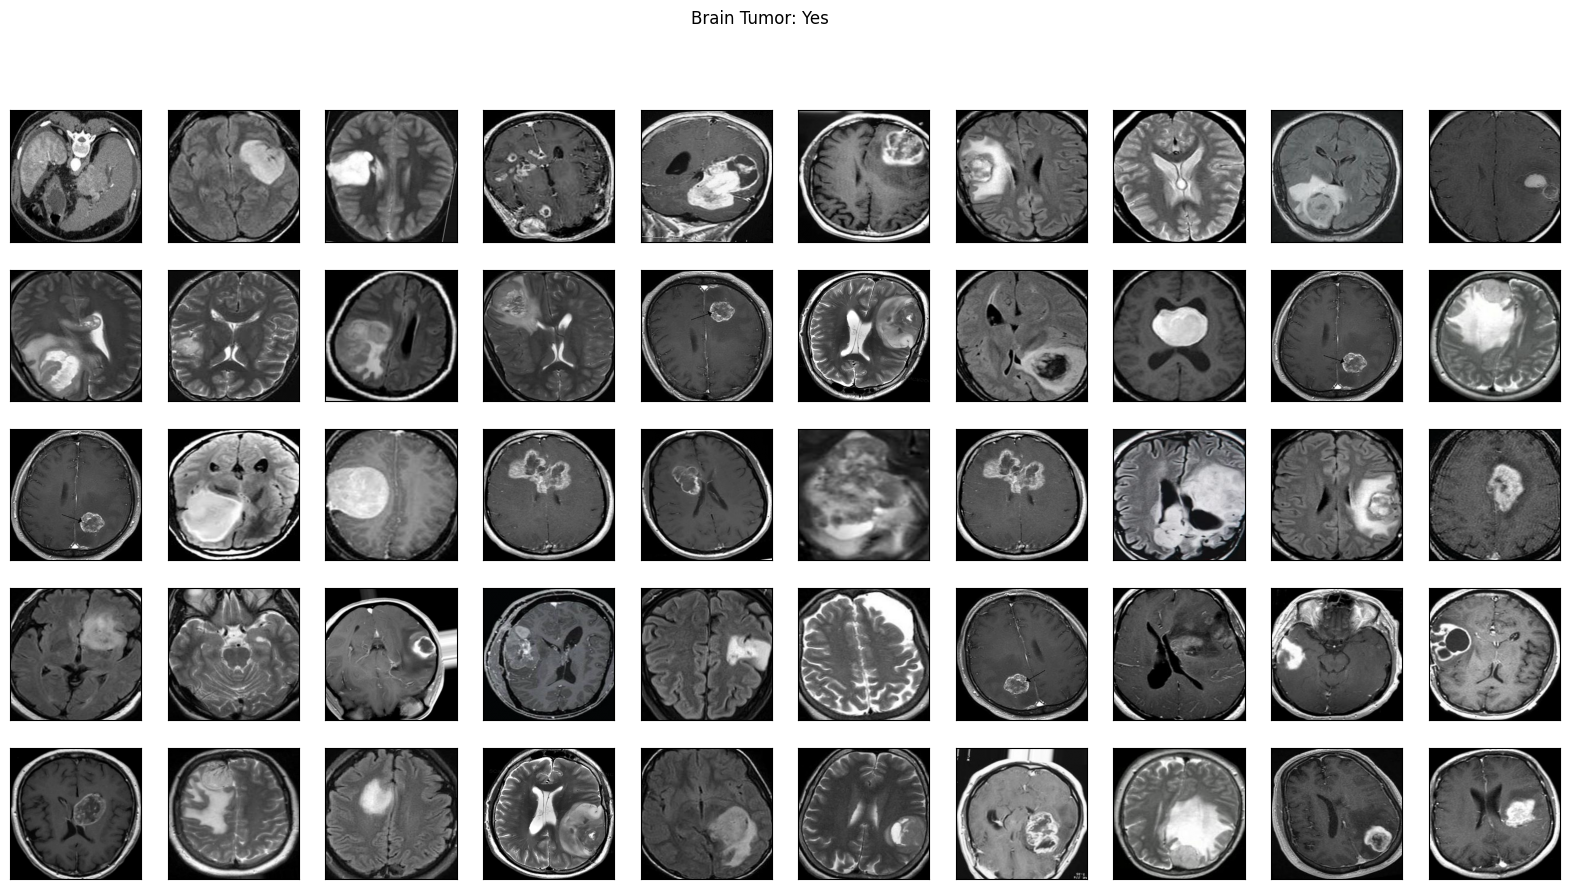

In [7]:
plot_sample_images(X, y)

In [8]:
def split_data(X, y, test_size=0.2):

    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """

    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [9]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [10]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


In [11]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [12]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)

    score = f1_score(y_true, y_pred)

    return score

In [13]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape.
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)

    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32)

    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)

    # FLATTEN X
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')

    return model

In [14]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [15]:
model = build_model(IMG_SHAPE)

In [16]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 244, 244, 3)      0         
 2D)                                                             
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 59, 59, 32)        0         
                                               

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [19]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_acc:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max'))

In [20]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard])

end_time = time.time()
execution_time = (end_time - start_time)
# print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
46/46 [==============================] - 214s 5s/step - loss: 0.8137 - accuracy: 0.6429 - val_loss: 0.6776 - val_accuracy: 0.5742
Epoch 2/10
46/46 [==============================] - 205s 4s/step - loss: 0.5106 - accuracy: 0.7529 - val_loss: 0.6434 - val_accuracy: 0.6258
Epoch 3/10
46/46 [==============================] - 200s 4s/step - loss: 0.4482 - accuracy: 0.7931 - val_loss: 0.6087 - val_accuracy: 0.6355
Epoch 4/10
46/46 [==============================] - 205s 4s/step - loss: 0.3956 - accuracy: 0.8346 - val_loss: 0.5387 - val_accuracy: 0.7323
Epoch 5/10
46/46 [==============================] - 195s 4s/step - loss: 0.3451 - accuracy: 0.8512 - val_loss: 0.4921 - val_accuracy: 0.7806
Epoch 6/10
46/46 [==============================] - 194s 4s/step - loss: 0.3473 - accuracy: 0.8478 - val_loss: 0.4651 - val_accuracy: 0.7710
Epoch 7/10
46/46 [==============================] - 194s 4s/step - loss: 0.3324 - accuracy: 0.8561 - val_loss: 0.6921 - val_accuracy: 0.6806
Epoch 8/10
46

In [21]:
history = model.history.history
print(history)

{'loss': [0.8136755228042603, 0.5106321573257446, 0.4482312500476837, 0.3955943286418915, 0.3450694680213928, 0.34734806418418884, 0.33237019181251526, 0.2749626338481903, 0.26480382680892944, 0.2970328629016876], 'accuracy': [0.6429065465927124, 0.7529411911964417, 0.7930795550346375, 0.8346020579338074, 0.8512110710144043, 0.8477508425712585, 0.8560553789138794, 0.8837370276451111, 0.8941176533699036, 0.879584789276123], 'val_loss': [0.6776062846183777, 0.6434494853019714, 0.6086719036102295, 0.5387464165687561, 0.4921371042728424, 0.4650614559650421, 0.6920635104179382, 0.46760764718055725, 0.42907434701919556, 0.43042096495628357], 'val_accuracy': [0.57419353723526, 0.625806450843811, 0.6354838609695435, 0.7322580814361572, 0.7806451320648193, 0.7709677219390869, 0.6806451678276062, 0.7838709950447083, 0.7967742085456848, 0.8096774220466614]}


In [22]:
def plot_metrics(history):

    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']

    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

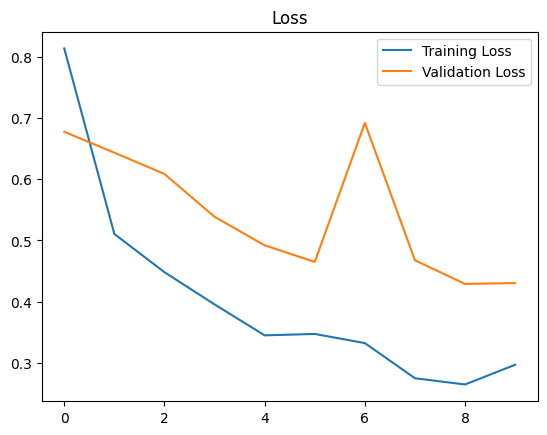

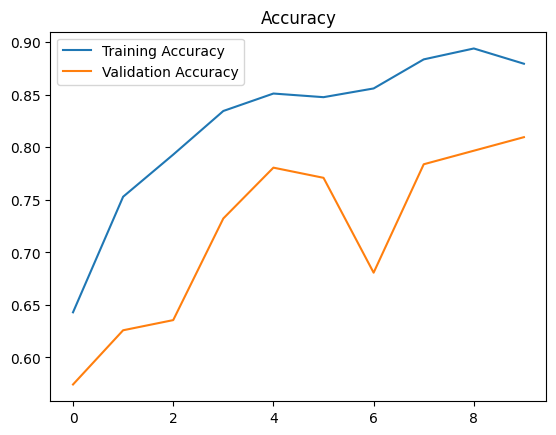

In [23]:
plot_metrics(history)

In [24]:
loss, acc = model.evaluate(x=X_test, y=y_test)

10/10 [==============================] - 12s 1s/step - loss: 0.3743 - accuracy: 0.8548


In [ ]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

In [26]:
y_test_prob = model.predict(X_test)
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

10/10 [==============================] - 9s 888ms/step
F1 score: 0.8688046647230321
